In [1]:
import sys
sys.path.append('..')

import cv2

import numpy as np
import matplotlib.pyplot as plt
from src.classical_tracker import ClassicalTracker
import importlib
import src.deep_tracker
importlib.reload(src.deep_tracker)
from src.deep_tracker import DeepTracker
import torch
from pathlib import Path
from src.siamese_tracker import SiameseTracker
from src.ostrack import OSTrack
VIDEO_PATH_MUG = '../Test-Videos/Antoine_Mug.mp4'
VIDEO_PATH_BALL='../Test-Videos/VOT-ball.mp4'
VIDEO_PATH_BASKET = '../Test-Videos/VOT-Basket.mp4'
VIDEO_PATH_CAR='../Test-Videos/VOT-Car.mp4'
VIDEO_PATH_SUNSHADE='../Test-Videos/VOT-Sunshade.mp4'
VIDEO_PATH_WOMAN='../Test-Videos/VOT-Woman.mp4'
device = 'msg' if torch.cuda.is_available() else 'cpu'


In [ ]:
# Run multiple methods interactively (one by one)
# For each method you'll be able to select ROI on the first frame and then
# the tracker will run and save results to ../results/evaluation/{method}_mug

methods_to_run = [
    {'name': 'meanshift_hue', 'kind': 'classical', 'method': 'meanshift', 'color_space': 'hue'},
    # {'name': 'meanshift_hsv', 'kind': 'classical', 'method': 'meanshift', 'color_space': 'hsv'},
    {'name': 'adaptive_hue', 'kind': 'classical', 'method': 'meanshift', 'color_space': 'hue', 'update_model': True, 'update_rate': 0.1},
    # {'name': 'hough_basic', 'kind': 'classical', 'method': 'hough'},
    # {'name': 'predictive_hough', 'kind': 'classical', 'method': 'predictive_hough'},
    {'name': 'deep_meanshift', 'kind': 'deep', 'model_name': 'resnet50', 'layer_name': 'layer3', 'top_k_channels': 64},
]

for m in methods_to_run:
    exp_name = f"{m['name']}_sunshade"
    out_dir = Path(f"../results/evaluation/{exp_name}")
    out_dir.mkdir(parents=True, exist_ok=True)
    print('\n' + '='*60)
    print(f"Starting interactive run for: {m['name']}\nResults will be saved to: {out_dir}")
    print("Instructions: select ROI on the first frame, press SPACE/ENTER to confirm. During tracking press ESC to stop, 's' to save frame.")

    try:
        if m['kind'] == 'classical':
            tr = ClassicalTracker(
                video_path=VIDEO_PATH_SUNSHADE,
                method=m.get('method','meanshift'),
                color_space=m.get('color_space','hsv'),
                update_model=m.get('update_model', False),
                update_rate=m.get('update_rate', 0.05),
            )
            tr.track_video(visualize=True, visualize_process=True,  
                            save_result=True,output_dir=str(out_dir))

        elif m['kind'] == 'deep':
            tr = DeepTracker(
                video_path=VIDEO_PATH_SUNSHADE,
                model_name=m.get('model_name','resnet50'),
                layer_name=m.get('layer_name','layer3'),
                top_k_channels=m.get('top_k_channels',64),
                device=device if 'device' in globals() else 'cpu'
            )
            tr.track_video(visualize=True,
                            save_result=True, output_dir=str(out_dir))

        else:
            print('Unknown method kind:', m)

    except Exception as e:
        print(f"Error running {m['name']}: {e}")
        continue

print('\nAll interactive runs completed.')


Starting interactive run for: deep_meanshift
Results will be saved to: ../results/evaluation/deep_meanshift_sunshade
Instructions: select ROI on the first frame, press SPACE/ENTER to confirm. During tracking press ESC to stop, 's' to save frame.
Q6 Step 1: Select ROI on first frame
DEBUG: Creating window 'First image'
DEBUG: Frame shape: (288, 352, 3)
DEBUG: Window created, showing frame...
Q6 Step 2: Initialize DeepTracker (CNN features + template)
Q6 Step 3: Start deep mean-shift tracking
Press 's' to save frame, 'ESC' to exit

Q6: Deep tracking completed. Total frames: 171

All interactive runs completed.


In [11]:
# Run multiple methods interactively (one by one)
# This cell runs: a Deep Siamese experiment (using src.siamese_tracker if available)
# and three OSTrack experiments (invoking OSTrack scripts if present).
from pathlib import Path
import subprocess
import os

# Use the car video for all experiments as requested
VIDEO = globals().get('VIDEO_PATH_WOMAN', '../Test-Videos/VOT-Woman.mp4')

# Define experiments: deep meanshift + siamese + ostrack variants
methods_to_run = [
    {"name": "deep_meanshift", "kind": "deep", "model_name": "resnet50", "layer_name": "layer3", "top_k_channels": 64},
    {"name": "deep_siamese", "kind": "siamese", "model": "siamfc", "checkpoint": "/Users/wuwanxing/Documents/projects/python/object_tracking/siamfc-pytorch/siamfc_alexnet_e50.pth"},
    {"name": "ostrack_default", "kind": "ostrack", "config": "vitb_256_mae_32x4_ep300"},
]

for m in methods_to_run:
    exp_name = f"{m['name']}_woman"
    out_dir = Path(f"../results/evaluation/{exp_name}")
    out_dir.mkdir(parents=True, exist_ok=True)
    print('\n' + '='*60)
    print(f"Starting interactive run for: {m['name']}\nResults will be saved to: {out_dir}")
    print("Instructions: if a GUI selection is required, select ROI on the first frame. Press ESC to stop, 's' to save frame.")

    try:
        if m['kind'] == 'classical':
            tr = ClassicalTracker(
                video_path=VIDEO,
                method=m.get('method','meanshift'),
                color_space=m.get('color_space','hsv'),
                update_model=m.get('update_model', False),
                update_rate=m.get('update_rate', 0.1),
            )
            tr.track_video(visualize=True, visualize_process=True, save_result=True, output_dir=str(out_dir))

        elif m['kind'] == 'deep':
            tr = DeepTracker(
                video_path=VIDEO,
                model_name=m.get('model_name','resnet50'),
                layer_name=m.get('layer_name','layer3'),
                top_k_channels=m.get('top_k_channels',64),
                device=globals().get('device','cpu')
            )
            tr.track_video(visualize=True, save_result=True, output_dir=str(out_dir))

        elif m['kind'] == 'siamese':
            # Use src.siamese_tracker.SiameseTracker
            try:
                from src.siamese_tracker import SiameseTracker
                tracker = SiameseTracker(
                    video_path=VIDEO,
                    net_path=m.get('checkpoint'),  # IMPORTANT: pass the model path
                    device='cpu',  # change to 'cuda' if you have a GPU
                    debug=False
                )
                # Save tracking results and visualize
                tracker.track_video(visualize=True, save_result=True, output_dir=str(out_dir))
            except Exception as e:
                print('Siamese tracker failed or not available:', e)

        elif m['kind'] == 'ostrack':
            # Use src.ostrack.OSTrack
            try:
                import sys
                sys.path.append('..')
                from src.ostrack import OSTrack
                
                tracker = OSTrack(
                    video_path=VIDEO,
                    config_name=m.get('config', 'vitb_256_mae_32x4_ep300'),  # 对应 experiments/ostrack/vitb_256_mae_32x4_ep300.yaml
                    device='cpu',  # 或 'cuda:0'
                    debug=True
                )
                tracker.track_video(visualize=True, save_result=True, output_dir=str(out_dir))
            except Exception as e:
                print('OSTrack failed:', e)

        else:
            print('Unknown method kind:', m)

    except Exception as e:
        print(f"Error running {m['name']}: {e}")
        continue

print('\nAll interactive runs completed.')


Starting interactive run for: deep_meanshift
Results will be saved to: ../results/evaluation/deep_meanshift_woman
Instructions: if a GUI selection is required, select ROI on the first frame. Press ESC to stop, 's' to save frame.
Q6 Step 1: Select ROI on first frame
DEBUG: Creating window 'First image'
DEBUG: Frame shape: (288, 352, 3)
DEBUG: Window created, showing frame...


2025-11-19 03:27:29.678 python[99937:7458868] error messaging the mach port for IMKCFRunLoopWakeUpReliable


Q6 Step 2: Initialize DeepTracker (CNN features + template)
Q6 Step 3: Start deep mean-shift tracking
Press 's' to save frame, 'ESC' to exit

Q6: Deep tracking completed. Total frames: 596

Starting interactive run for: deep_siamese
Results will be saved to: ../results/evaluation/deep_siamese_woman
Instructions: if a GUI selection is required, select ROI on the first frame. Press ESC to stop, 's' to save frame.
Loading pretrained SiamFC model...
✓ Pretrained Siamese network loaded!

=== ROI Selection ===
1. Drag to select the target
2. Press ENTER or SPACE to confirm
3. Press 'c' to cancel

Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!

Initializing real Siamese network...
Results will be saved to: ../results/evaluation/deep_siamese_woman

🎯 Tracking with REAL Siamese Network (GOT-10k trained)
Press ESC to quit | Press 'p' to pause

📊 Frame 50 | Avg FPS: 18.2
📊 Frame 100 | Avg FPS: 18.9
📊 Frame 150 | Avg FPS: 18.7
📊 Frame 200 | Av

/opt/anaconda3/envs/cv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/anaconda3/envs/cv/lib/python3.13/site-packages/timm/models/helpers.py:7: FutureWarning: Importing from timm.models.helpers is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/opt/anaconda3/envs/cv/lib/python3.13/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/opt/anaconda3/envs/cv/lib/python3.13/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  

[OSTrack wrapper] Created EvalTracker(name='ostrack', param='vitb_256_mae_32x4_ep300', dataset='video_demo')
[OSTrack wrapper] Saving frame PNGs to: ../results/evaluation/ostrack_default_woman
Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!
[OSTrack wrapper] Using optional_box = (207.0, 121.0, 29.0, 99.0)
[OSTrack wrapper] cv2.imshow has been patched for frame saving.
test config:  {'MODEL': {'PRETRAIN_FILE': 'mae_pretrain_vit_base.pth', 'EXTRA_MERGER': False, 'RETURN_INTER': False, 'RETURN_STAGES': [], 'BACKBONE': {'TYPE': 'vit_base_patch16_224', 'STRIDE': 16, 'MID_PE': False, 'SEP_SEG': False, 'CAT_MODE': 'direct', 'MERGE_LAYER': 0, 'ADD_CLS_TOKEN': False, 'CLS_TOKEN_USE_MODE': 'ignore', 'CE_LOC': [], 'CE_KEEP_RATIO': [], 'CE_TEMPLATE_RANGE': 'ALL'}, 'HEAD': {'TYPE': 'CENTER', 'NUM_CHANNELS': 256}}, 'TRAIN': {'LR': 0.0004, 'WEIGHT_DECAY': 0.0001, 'EPOCH': 300, 'LR_DROP_EPOCH': 240, 'BATCH_SIZE': 32, 'NUM_WORKER': 10, 'OPTIMIZER': 

### 对比展示（按帧）

下面的代码会读取 `results/evaluation/*_mug/Frame_*.png`（若缺失会尝试用 `predictions.csv` + `VIDEO_PATH_MUG` 从视频帧绘制框作退路），并为每个指定的帧生成一张横向对比图（每列一个方法）。

- 编辑 `methods` 列表选择你想对比的方法目录（默认会自动发现）。
- 编辑 `frames_to_show` 选择要展示的帧编号（与 `Frame_0001.png` 的编号对应）。
- 输出会显示在 notebook 中，并保存到 `results/evaluation/comparison_frames/`。


Found method directories: ['hough_basic_ball', 'predictive_hough_ball', 'deep_meanshift_ball']
Looking for frame image at: ../results/evaluation/hough_basic_ball/Frame_0010.png
Looking for frame image at: ../results/evaluation/hough_basic_ball/Frame_0125.png
Looking for frame image at: ../results/evaluation/hough_basic_ball/Frame_0300.png
Looking for frame image at: ../results/evaluation/hough_basic_ball/Frame_0500.png
Looking for frame image at: ../results/evaluation/hough_basic_ball/Frame_0580.png


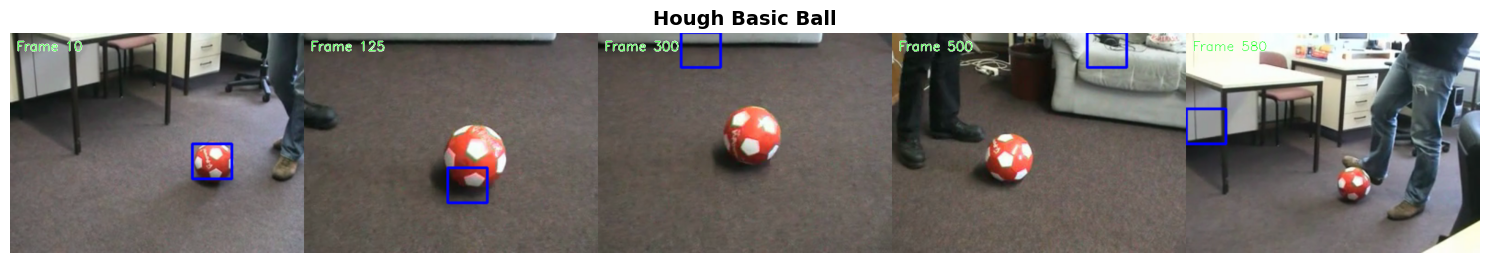

Saved montage for hough_basic_ball -> ../results/evaluation/comparison_frames/hough_basic_ball_frames.png
Looking for frame image at: ../results/evaluation/predictive_hough_ball/Frame_0010.png
Looking for frame image at: ../results/evaluation/predictive_hough_ball/Frame_0125.png
Looking for frame image at: ../results/evaluation/predictive_hough_ball/Frame_0300.png
Looking for frame image at: ../results/evaluation/predictive_hough_ball/Frame_0500.png
Looking for frame image at: ../results/evaluation/predictive_hough_ball/Frame_0580.png


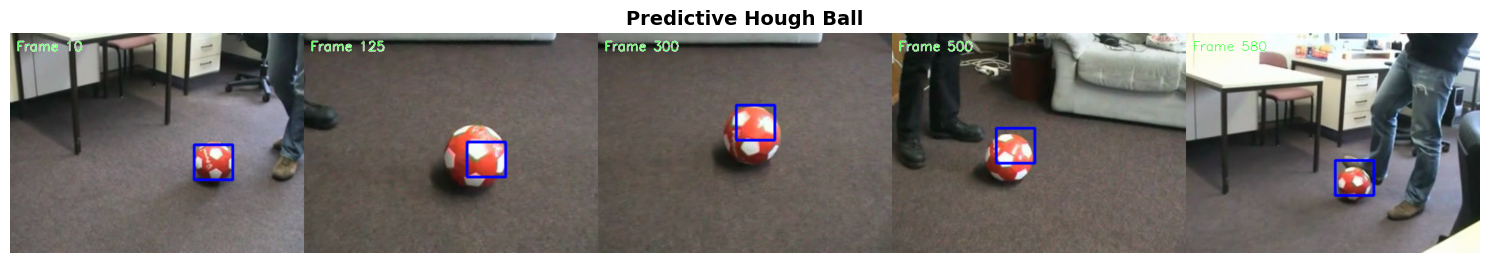

Saved montage for predictive_hough_ball -> ../results/evaluation/comparison_frames/predictive_hough_ball_frames.png
Looking for frame image at: ../results/evaluation/deep_meanshift_ball/Frame_0010.png
Looking for frame image at: ../results/evaluation/deep_meanshift_ball/Frame_0125.png
Looking for frame image at: ../results/evaluation/deep_meanshift_ball/Frame_0300.png
Looking for frame image at: ../results/evaluation/deep_meanshift_ball/Frame_0500.png
Looking for frame image at: ../results/evaluation/deep_meanshift_ball/Frame_0580.png


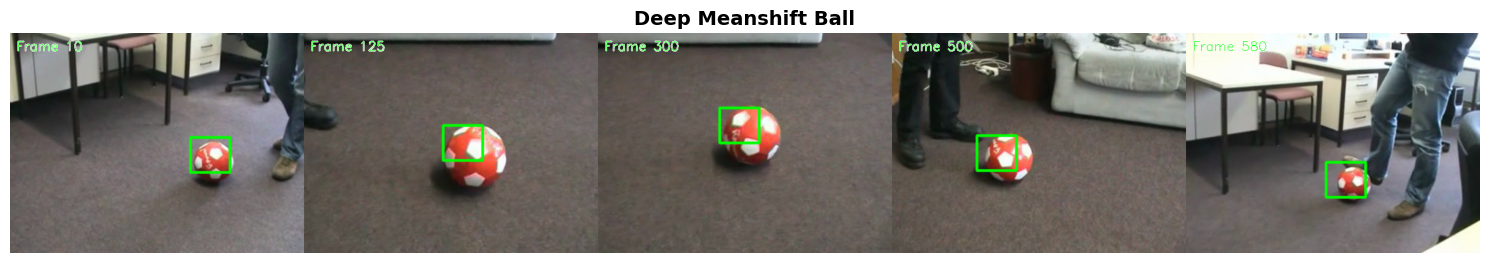

Saved montage for deep_meanshift_ball -> ../results/evaluation/comparison_frames/deep_meanshift_ball_frames.png


In [2]:
# Cell: 为每个方法生成多帧展示（每方法一行/一图）
from pathlib import Path
import glob, os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 配置（按需修改）
ROOT = Path('../results/evaluation')
OUT = ROOT / 'comparison_frames'
OUT.mkdir(parents=True, exist_ok=True)

# 自动发现含 Frame_*.png 的方法目录；若想手动指定，把 auto=False 并写 methods 列表
auto = False
if not auto:
    methods = [
        # 'deep_meanshift_woman',
        # 'deep_siamese_woman',
        # 'ostrack_default_woman',
        # "meanshift_hue_sunshade",
        # "adaptive_hue_sunshade",
        # "deep_meanshift_sunshade",
        "hough_basic_ball",
        "predictive_hough_ball",
        "deep_meanshift_ball",
    ]
else:
    methods = []
    for p in sorted(ROOT.iterdir()):
        if p.is_dir():
            # 检查是否有 process 子目录中的帧图像
            process_dir = p #/ 'process'
            if process_dir.exists() and any(process_dir.glob('Frame_*.png')):
                methods.append(p.name)

print('Found method directories:', methods)

# 要展示的帧编号（与 Frame_XXXX 编号对应）
frames_to_show = [10,125,300,500,580]

# 回退 video path（当没有 Frame_*.png 时，用 predictions.csv 在视频上绘框）
VIDEO_FALLBACK = globals().get('VIDEO_PATH_WOMAN', '../Test-Videos/VOT-Woman.mp4')

# helper: 读取帧或回退绘制
def read_frame_image(method_dir, frame_idx, target_size=None):
    process = ROOT / method_dir
    p = process / f'Frame_{frame_idx:04d}.png'
    print('Looking for frame image at:', p)
    if p.exists():
        im = cv2.imread(str(p))
        if im is not None:
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
            if target_size is not None:
                im = cv2.resize(im, target_size)
            return im
    
    # 回退：用 predictions.csv + 视频绘制
    pred_csv = ROOT / method_dir / 'predictions.csv'
    if pred_csv.exists() and os.path.exists(VIDEO_FALLBACK):
        try:
            df = pd.read_csv(pred_csv)
            # 检查是否有frame列
            if 'frame' in df.columns:
                df = df.set_index('frame')
            if frame_idx in df.index:
                cap = cv2.VideoCapture(VIDEO_FALLBACK)
                cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx - 1)
                ret, frame = cap.read()
                cap.release()
                if ret:
                    x = int(df.loc[frame_idx, 'x'])
                    y = int(df.loc[frame_idx, 'y'])
                    w = int(df.loc[frame_idx, 'w'])
                    h = int(df.loc[frame_idx, 'h'])
                    bgr = frame.copy()
                    cv2.rectangle(bgr, (x, y), (x + w, y + h), (0, 255, 0), 2)
                    im = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
                    if target_size is not None:
                        im = cv2.resize(im, target_size)
                    return im
        except Exception as e:
            print(f'Failed to load from predictions.csv: {e}')
    
    # 最后回退空白
    if target_size is None:
        return np.zeros((360, 640, 3), dtype=np.uint8)
    else:
        return np.zeros((target_size[1], target_size[0], 3), dtype=np.uint8)

# 为每个方法生成一张包含多个帧的横向对比图并保存
for m in methods:
    imgs = []
    for fid in frames_to_show:
        im = read_frame_image(m, fid)
        imgs.append(im)
    
    # 统一尺寸：以第一个有效图像为参考
    ref = next((im for im in imgs if im is not None and im.size > 0), None)
    if ref is None:
        print('No images for', m)
        continue
    
    H, W = ref.shape[:2]
    # resize all to same H (preserve aspect by scaling width proportionally)
    resized = []
    target_h = 360
    for im in imgs:
        if im is None or im.size == 0:
            im2 = np.zeros((target_h, int(target_h * W / H), 3), dtype=np.uint8)
        else:
            h0, w0 = im.shape[:2]
            scale = target_h / float(h0)
            w_new = int(round(w0 * scale))
            im2 = cv2.resize(im, (w_new, target_h))
        resized.append(im2)
    
    # 拼接横向
    total_w = sum(im.shape[1] for im in resized)
    canvas = np.zeros((target_h, total_w, 3), dtype=np.uint8)
    x = 0
    for im in resized:
        w = im.shape[1]
        canvas[:, x:x+w] = im
        x += w
    
    # 绘制标注（帧号）在图上
    canvas_bgr = cv2.cvtColor(canvas, cv2.COLOR_RGB2BGR)
    x = 0
    font = cv2.FONT_HERSHEY_SIMPLEX
    for im, fid in zip(resized, frames_to_show):
        w = im.shape[1]
        cv2.putText(canvas_bgr, f'Frame {fid}', (x + 10, 30), font, 0.7, (255, 255, 255), 2)
        cv2.putText(canvas_bgr, f'Frame {fid}', (x + 10, 30), font, 0.7, (0, 255, 0), 1)
        x += w
    
    canvas_rgb = cv2.cvtColor(canvas_bgr, cv2.COLOR_BGR2RGB)
    
    # 保存并展示
    out_path = OUT / f'{m}_frames.png'
    plt.figure(figsize=(15, 4))
    # Title: method name formatted
    title = m.replace('_', ' ').title()
    plt.title(title, fontsize=14, fontweight='bold')
    plt.imshow(canvas_rgb)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(str(out_path), bbox_inches='tight', dpi=150)
    plt.show()
    plt.close()
    print('Saved montage for', m, '->', out_path)